# Volatility Analysis
This notebook adresses Chapter 1 of our research project, namely analyzing the stability of stock volatility (standard deviation of returns) over time.

In [1]:
import pandas as pd
import numpy as np
import wrds
import pandas_market_calendars as mcal
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
# conn = wrds.Connection(wrds_username='kaihvc')

## Data Collection
The goal of this section is to generate a dataset of weekly returns (Fri-Fri) for each stock in our universe.

### Querying WRDS for Daily Returns
We query the WRDS CRSP stock database for daily returns for any stock with a 2020 $10mil market cap (adjusted for inflation using the GDP deflator)

In [2]:
# WRDS database request & processing
# build SQL query using inflation-adjusted mcaps

# load inflation-adjusted market caps from file (equivalents of 2020 $10mil)
def get_cutoffs(filename):
    cutoffs = pd.read_csv(filename)[['observation_date', 'Cutoff Value']]
    cutoffs['year'] = pd.to_datetime(cutoffs['observation_date']).apply(lambda x: x.year)
    cutoffs = cutoffs.set_index('year').drop(columns='observation_date')
    return cutoffs

# build query, filtering using inflation-adjusted mcap values
def build_query(start_dt, end_dt, adjusted_mcaps):
    query = f"SELECT cusip, date, ret FROM crsp.dsf WHERE date>='{str(start_dt)}' AND date<='{str(end_dt)}' AND ("
    for i, year in enumerate(adjusted_mcaps.loc[start_dt.year:].index):
        query += f"(EXTRACT(YEAR FROM date)={year} AND prc*shrout>={int(adjusted_mcaps.loc[year][0] / 1000)})"
        query += " OR " if i < len(adjusted_mcaps.loc[start_dt.year:].index) - 1 else ")"
    return query
        
# get daily returns
def get_returns(start_dt, end_dt, adjusted_mcaps, username='kaihvc'):
    conn = wrds.Connection(wrds_username=username)
    query = build_query(start_dt, end_dt, adjusted_mcaps)
    df = conn.raw_sql(query)
    return df

In [2]:
# parameters
# we'll use the 1950 inflation-adjusted equivalent of a 2020 $10mil mcap minimum, and do more fine-grained filtering later
start_dt = date(1950, 1, 1)
end_dt = date(2021, 1, 1)

In [4]:
# query returns
requery = False
if requery:
    exec_start = datetime.now()
    print("Querying WRDS for daily returns...")
    daily_rets = get_returns(start_dt, end_dt, get_cutoffs('inflation_adjustments.csv'))
    print(f"Query complete in {str(datetime.now() - exec_start)}, writing to disk...")
    stage_start = datetime.now()
    daily_rets.to_csv('wrds_results/daily_rets_adjusted.csv')
    print(f"Disk write complete in {str(datetime.now() - stage_start)}")
    print(f"Download complete in {str(datetime.now() - exec_start)}")

### Converting Daily Data to Weekly Data
To convert our daily data into weekly data, we'll neeed to delineate the weeks (excluding market holidays, defining minimum days, etc.). We'll then geometrically expand each week's daily returns ($r_d$ for each day $d$) to get the weekly return $r_w$ as:  
$r_w = ((1 + r_1) \cdot (1 + r_2) \cdot (1 + r_3) \cdot (1 + r_4) \cdot (1 + r_5)) - 1$ 

In [5]:
def pd_process_weekly(df, start_dt, end_dt):
    
    # takes ~25-30 min on my machine (16G, 2.8GHz) all told; most spent on the aggregation
    # group by cusip & weeks, then geometrically expand week groups to get weekly returns
    df['date'] = pd.to_datetime(df['date'])
    grouper = pd.Grouper(key='date', freq='W-MON')
    grouped = df.groupby(by=['cusip', grouper], observed=True)
    weekly_rets = grouped.agg({'ret': lambda x: (x + 1).product() - 1})
    
    return weekly_rets

In [6]:
# calculate returns
load = False
if load:
    recalc = False
    if recalc:
        if 'daily_rets' not in globals():
            print("Loading daily returns from file...")
            daily_rets = pd.read_csv('wrds_results/daily_rets_adjusted.csv', index_col=0)
        exec_start = datetime.now()
        weekly_rets = pd_process_weekly(daily_rets, start_dt, end_dt)
        print(f"Processing complete in {str(datetime.now() - exec_start)}, writing to disk...")
        weekly_rets.to_csv('wrds_results/weekly_rets_adjusted.csv')
        print(f'Weekly returns downloaded in {str(datetime.now() - exec_start)}')
    else:
        weekly_rets = pd.read_csv('wrds_results/weekly_rets_adjusted.csv', index_col=[0, 1])
        weekly_rets.index = weekly_rets.index.set_levels([weekly_rets.index.levels[0], pd.to_datetime(weekly_rets.index.levels[1])])
        print('Weekly returns loaded')

## Data Processing
Once we have weekly returns, we want to calculate their standard deviations over a ~6-month period for each stock, which will be our primary source of data on the stocks' volatility.

### Generating 6mo. Standard Deviations
Calculating standard deviations is relatively straightforward; the main caveat is generating the periods. We'll be using periods of _approximately_ 26 weeks, with occasional corrections to avoid drift (we want to start as close to the first trading week of the year, or the 26th week of the year, as we can).

In [3]:
def get_days(start_dt, end_dt):
    nyse = mcal.get_calendar('NYSE')
    return [day.date() for day in nyse.valid_days(start_date=str(start_dt), 
                                                end_date=str(end_dt))]

def get_weeks(start_dt, end_dt):
    weeks = []

    # get trading days and divide into weeks, rolling over on the given rollover day
    current_week = []
    days = get_days(start_dt, end_dt)
    for i, day in enumerate(days):
        # append to current week
        current_week.append(day)

        #end of the week check
        if i+1<len(days):
            next_day = days[i+1]
            if next_day.weekday() < day.weekday(): #if the next day's weekday comes before the current, then the next_day is in a new week
                weeks.append(current_week)
                current_week = []
            elif (next_day-day).days > 4: #if the condition above didnt pass, check that >4 days didnt pass as well
                weeks.append(current_week)
                current_week = []

    # append final week, even if it wasn't a full week period
    if current_week: weeks.append(current_week)

    return weeks

def get_periods(weeks):
    periods = []
    start_date = weeks[0][0]
    end_date = None
    for i in range(len(weeks)-1):
        start = weeks[i][0] #this monday
        end = weeks[i][-1]  #this friday

        next_start = weeks[i+1][0] #next monday
        next_end = weeks[i+1][-1]  #next friday

        #if the current friday is in december, and the next weeks friday is in january, this is the end of one period
        #the very next week will be the very start of the period\
        if end.month == 12 and next_end.month == 1:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
        #if the last day is in june, and the next weeks last day is in july, this is the end of one period
        #the very next week will be the very start of the period
        if end.month == 6 and next_end.month == 7:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
    periods.append([start_date, weeks[i+1][-1]])
    for i in periods:
        i[1] += timedelta(days=3)
    return periods

In [6]:
# calculate standard deviations of ~26 week periods; 
# must have min_valid_weeks (default 20) out of 26 to be valid
def get_6mo_stds(weekly_rets, periods, min_valid_weeks=20):
    
    num_pers = len(periods)
    devs_df_list = []
    devs = pd.DataFrame(index=weekly_rets.index.levels[0], columns=['P' + str(i) for i in range(len(periods))])

    for i, per in enumerate(periods):
        
        clear_output(wait=True)
        iter_start = datetime.now()

        filter_counts = weekly_rets.loc[(slice(None), 
                                    slice(per[0], 
                                          per[1] - timedelta(days=1))), 
                                   :].groupby('cusip').count().rename(columns={'ret': 'count'})
        agg_devs = weekly_rets.loc[(slice(None), 
                                    slice(per[0], 
                                          per[1] - timedelta(days=1))), 
                                   :].groupby('cusip').agg(np.std).loc[filter_counts['count'] >= min_valid_weeks]
        devs.loc[agg_devs.index, 'P' + str(i)] = agg_devs.values.flatten()
#         devs_df_list.append(devs)
                
        iter_time = datetime.now() - iter_start
        print(f'Cusip {i + 1}/{num_pers} complete in {str(iter_time)}')
        print(f'Est. completion in {str(iter_time * (num_pers - (i + 1)))}')
        
#     try:
#         devs = pd.concat(devs_df_list).astype(float)
    return devs
#     except MemoryError:
#         print('Memory error encountered - attempting to remedy by dropping weekly_rets')
#         del weekly_rets
#         try:
#             devs = pd.concat(devs_df_list)
#             return devs
#         except MemoryError:
#             print('Remedy failed - reload weekly_rets and buy more memory!')
#             return -1
    
    return -1

In [3]:
recalc = False
if recalc:
    exec_start = datetime.now()
    periods = get_periods(get_weeks(start_dt, end_dt))
    df_devs = get_6mo_stds(weekly_rets, periods)
    print('Writing to file...')
    df_devs.to_csv('wrds_results/deviations_fixed.csv')
    print(f'Done in {str(datetime.now() - exec_start)}')
else:
    df_devs = pd.read_csv('wrds_results/deviations_fixed.csv',index_col=0).astype(float)
    print('Standard deviations loaded')

Standard deviations loaded


### Accuracy Check
I promise I write good code. Let's first check on the standard error bit, as to whether there are any values below $ -2 \sigma $ for each decade.

c:\users\kaih2\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


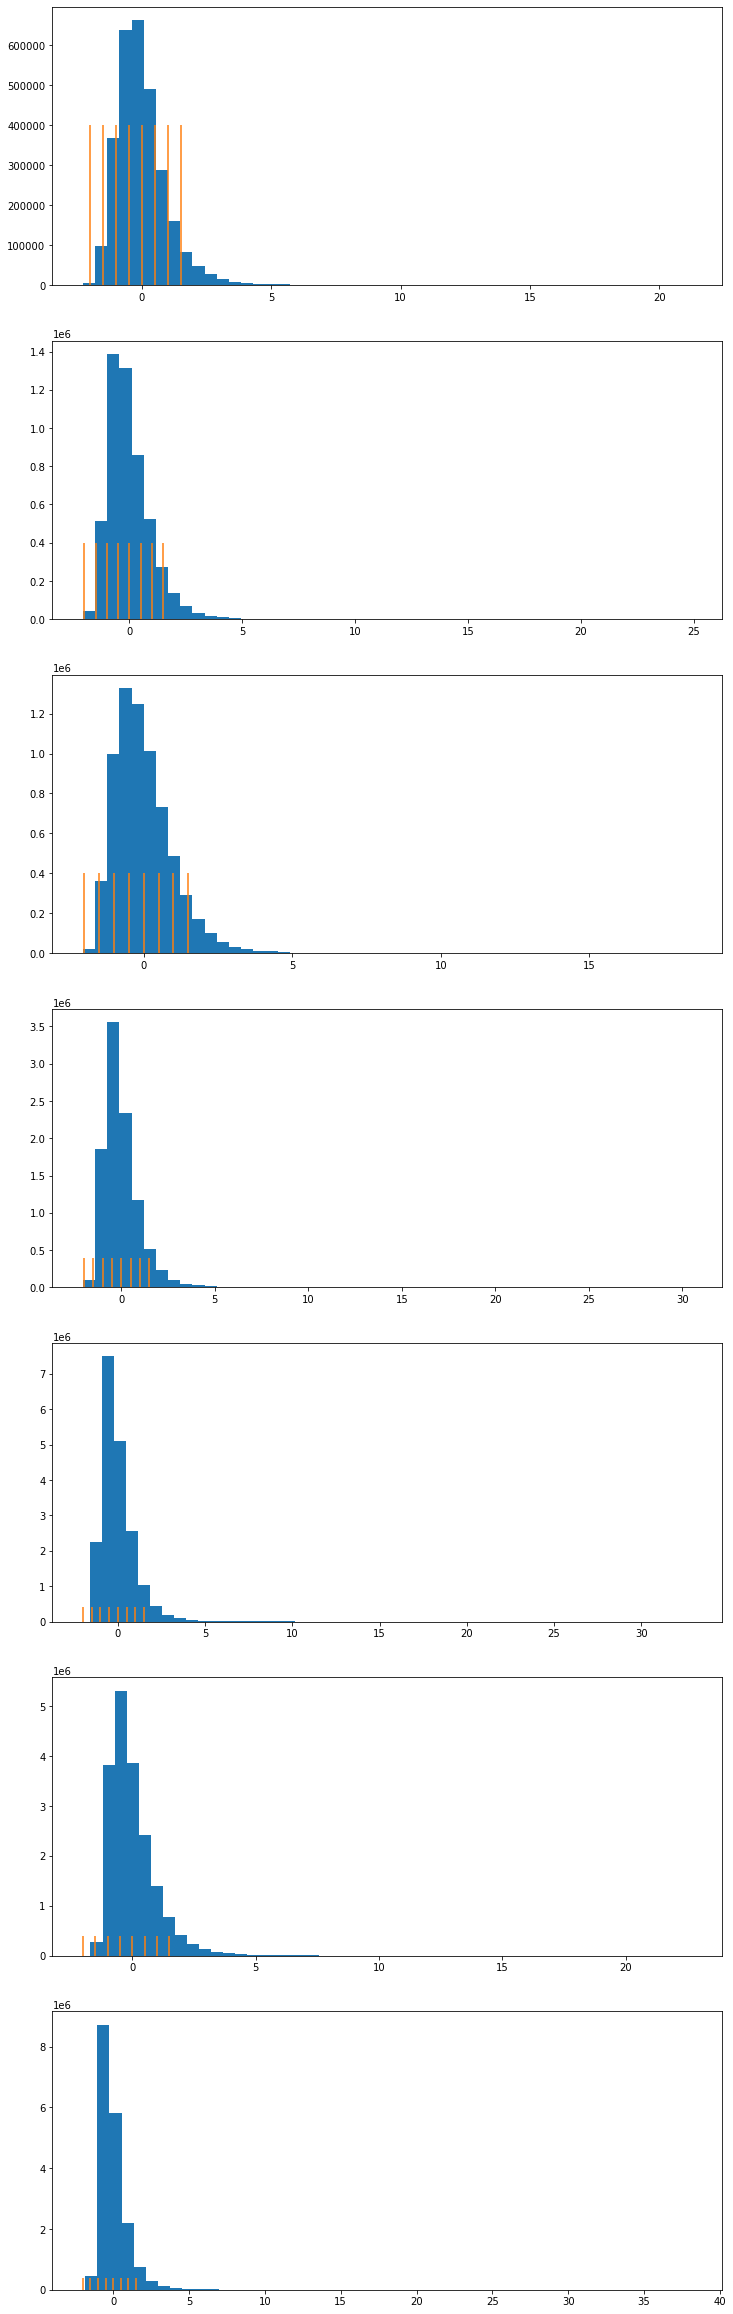

In [109]:
# stderr check
n_decades = 7
n_bins = 50
figs, axes = plt.subplots(nrows=n_decades, figsize=(12, 6 * n_decades))

for d in range(n_decades):
    df_decade = df_devs[df_devs.columns[20 * d:20 * (d + 1)]]
    norm_df = df_decade.copy()
    for col in df_decade.columns:
        norm_df[col] = (df_decade[col] - df_decade[col].mean()) / df_decade[col].std()
    
    axes[d].hist(norm_df.values.flatten(), n_bins)
    axes[d].vlines(np.mean(norm_df.values.flatten()), 0, 800000, color='red')
    axes[d].vlines(np.arange(-2, 2, 0.5), 0, 400000, color='tab:orange')
    
plt.show()

In [33]:
d1_vals = df_devs[df_devs.columns[:21]].values.flatten()
d1_vals = d1_vals[np.logical_not(np.isnan(d1_vals))]
norm_vals = (d1_vals - np.mean(d1_vals)) / np.std(d1_vals)

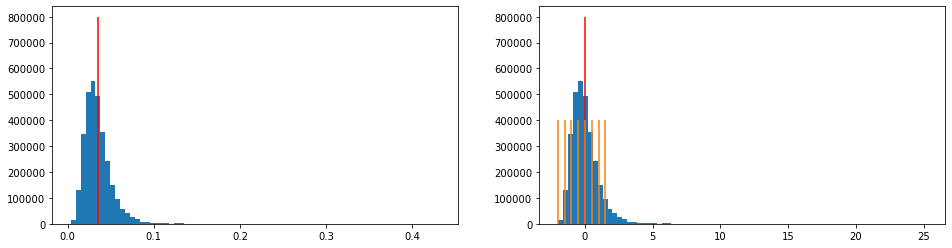

In [44]:
figs, axes = plt.subplots(ncols=2, figsize=(16, 4))
n_bins = 75

axes[0].hist(d1_vals, n_bins)
axes[0].vlines(np.mean(d1_vals), 0, 800000, color='red')

axes[1].hist(norm_vals, n_bins)
axes[1].vlines(np.mean(norm_vals), 0, 800000, color='red')
axes[1].vlines(np.arange(-2, 2, 0.5), 0, 400000, color='tab:orange')

plt.show()

# Ranking Stocks by Volatility
Now that we have data for volatility, we want to rank it in order to perform some stability analysis on it. We'll do this using both straight deciles, as well as which portion of the distribution the standard error of each value falls in.

#### Deciles
These are straight decile rankings - each ranking bin (1-10) contains 10% of the data.

In [5]:
# discretize into 10 bins
def discretize(df_devs, stderr=False, waiting_period=0):
    
    print('Beginning discretization...')
    
    if waiting_period > 0:
        for i, row in df_devs.iterrows():
            idxs = row.dropna().index[:waiting_period]
            row[idxs] = np.nan
            
    # BUGFIX 3/24: we shouldn't be dropping columns, because that'll mess up our transitions later on
#     df_devs = df_devs.dropna(axis='columns', how='all')
    
    df_disc = pd.DataFrame(columns=df_devs.columns)
    num_cols = len(df_devs.columns)
    
    if stderr:
        intervals = [pd.Interval(elt, elt + 0.5) for elt in np.arange(-2, 2, 0.5)]
        intervals = [pd.Interval(-np.inf, -2)] + intervals + [pd.Interval(2, np.inf)]    
        intervals = pd.IntervalIndex(intervals)
    
    for i, col in enumerate(df_devs.columns):
        iter_start = datetime.now()
        clear_output(wait=True)
        
        if stderr:
            
            stderr_col = (df_devs[col] - np.nanmean(df_devs[col])) / np.nanstd(df_devs[col])

            ''' 
                note: it's possible that not every period will include 10 categories, since this
                bins by set intervals rather than quantiles of the data itself.
            ''' 
            # all inline cause memory issues - save as much as we can, right?
            discretized = pd.cut(stderr_col, intervals, include_lowest=True)
            
            # BUGFIX 3/24: confirmed that labels are always the same
            labels = range(1, 11)
            vals = np.array(discretized.cat.rename_categories(labels))
        else:
            # however, this method *should* always include 10 categories for each period
            vals = pd.qcut(df_devs[col], 10, labels=range(1, 11))
        
        df_disc[col] = vals
        
        iter_time = datetime.now() - iter_start
        print(f'Column {i + 1}/{num_cols} complete in {str(iter_time)}')
        print(f'Est. completion in {str(iter_time * (num_cols - (i + 1)))}')
        
    return df_disc

In [4]:
load = True
recalc = False
if load:
    if recalc:
        exec_start = datetime.now()
        df_deciles = discretize(df_devs)
        print('Writing to file...')
        df_deciles.to_csv('wrds_results/ch1/deciles.csv')
        print(f'Done in {str(datetime.now() - exec_start)}')
    else:
        df_deciles = pd.read_csv('wrds_results/ch1/deciles.csv', index_col=0)
        print('Deciles loaded')

Deciles loaded


#### Standard Errors
These are rankings depending on which portion of the normal distribution the data fall into, defined by standard deviation. For given data point $d$, the bins are:   $ d < -2 \sigma, -2 \sigma < d < -1.5 \sigma, \cdots, 1.5 \sigma < d < 2 \sigma, 2 \sigma < d $

In [5]:
load = True
recalc = False
if load:
    if recalc:
        exec_start = datetime.now()
        df_stderrs = discretize(df_devs, stderr=True)
        print('Writing to file...')
        df_stderrs.to_csv('wrds_results/ch1/stderr.csv')
        print(f'Done in {str(datetime.now() - exec_start)}')
    else:
        df_stderrs = pd.read_csv('wrds_results/ch1/stderr.csv', index_col=0)
        print('Stderrs loaded')

Stderrs loaded


### Markov Modeling
Finally, for our stability analysis, we'll use the discretizations of our data (both deciles/standard errors) as "states" and build a Markov model to analyze how stocks transition between bins. We do this for each transition matrix, as well as one final

In [38]:
def get_transition_matrix(df, n_quantiles, df_vals, stderr=False):
    transition_matrices = []
    periods = [elt[:10] for elt in df.columns]
    if not len(periods) % 20 == 0:
        periods = periods[:-(len(periods) % 20)]
    n_decades = len(periods) // 20
    for i in range(n_decades):
        transition_matrices.append(np.zeros((n_quantiles + 1, n_quantiles + 1)))
        
    # get average val for each entry
    prev_avg_matrices = []
    post_avg_matrices = []
    for i in range(n_decades):
        prev_avg_matrices.append(np.zeros((n_quantiles + 1, n_quantiles + 1)))
        post_avg_matrices.append(np.zeros((n_quantiles + 1, n_quantiles + 1)))
                    
    # column-major cause Pandas
    for c_idx in range(len(periods) - 1):
        # start iteration
        print(f'Adding period {periods[c_idx]}...')
        clear_output(wait=True)
        iter_start = datetime.now()
        
        col = df[df.columns[c_idx]]
        next_col = df[df.columns[c_idx + 1]]
        for r_idx in range(len(df)):
            elt = col[r_idx]
            next_elt = next_col[r_idx]
            if (not np.isnan(elt)) and (not np.isnan(next_elt)):
                transition_matrices[c_idx // 20][int(elt)][int(next_elt)] += 1
                
                # note: we're adding one of these to the cell at (elt, next_elt) - can't recall which
                # (for now, we're using the value from the previous period)
                val = df_vals[df.columns[c_idx]].iloc[r_idx]
                next_val = df_vals[df.columns[c_idx + 1]].iloc[r_idx]
                
                if not np.isnan(val):
                    prev_avg_matrices[c_idx // 20][int(elt)][int(next_elt)] += val
                    
                if not np.isnan(next_val):
                    post_avg_matrices[c_idx // 20][int(elt)][int(next_elt)] += next_val
            

        print(f'Period {periods[c_idx]} complete in {str(datetime.now() - iter_start)}')
            
    # before normalization, divide average matrices by counts
    overall_prev = np.zeros((n_quantiles + 1, n_quantiles + 1))
    overall_post = np.zeros((n_quantiles + 1, n_quantiles + 1))
    for decade in range(n_decades):
        overall_prev += prev_avg_matrices[decade]
        overall_post += post_avg_matrices[decade]
        
        # check for division by 0
        for i in range(len(prev_avg_matrices[decade])):
            for j in range(len(prev_avg_matrices[decade][0])):
                if transition_matrices[decade][i][j] > 0:
                    prev_avg_matrices[decade][i][j] = prev_avg_matrices[decade][i][j] / transition_matrices[decade][i][j]
                    post_avg_matrices[decade][i][j] = post_avg_matrices[decade][i][j] / transition_matrices[decade][i][j]
                else:
                    prev_avg_matrices[decade][i][j] = 0
                    post_avg_matrices[decade][i][j] = 0
    
    # normalize transition matrix (decades & overall)
    overall_matrix = np.zeros((n_quantiles + 1, n_quantiles + 1))
    for decade in range(n_decades):
        overall_matrix += transition_matrices[decade]
        for i in range(n_quantiles + 1):
            mat_sum = np.sum(transition_matrices[decade][i])
            if mat_sum > 0:
                transition_matrices[decade][i] /= mat_sum
                
    # average overall matrix
    for i in range(len(overall_prev)):
        for j in range(len(overall_prev[0])):
            if overall_matrix[i][j] != 0:
                overall_prev[i][j] /= overall_matrix[i][j]
                overall_post[i][j] /= overall_matrix[i][j]
            else:
                overall_prev[i][j] = 0
                overall_post[i][j] = 0
    
    # normalize overall matrix
    for i in range(n_quantiles + 1):
        mat_sum = np.sum(overall_matrix[i])
        if mat_sum > 0:
            overall_matrix[i] /= mat_sum
            
    return transition_matrices + [overall_matrix], prev_avg_matrices + [overall_prev], post_avg_matrices + [overall_post]

In [39]:
dec = True
stderr = True
if dec:
    transition_mats_dec, prev_avg_dec, post_avg_dec = get_transition_matrix(df_deciles, 10, df_devs)
    for i in range(len(transition_mats_dec) - 1):
        np.save(f'wrds_results/ch1/transition_mat_deciles_{str(1950 + i * 10)}', transition_mats_dec[i])
        np.save(f'wrds_results/ch1/prev_average_mat_deciles_{str(1950 + i * 10)}', prev_avg_dec[i])
        np.save(f'wrds_results/ch1/post_average_mat_deciles_{str(1950 + i * 10)}', post_avg_dec[i])
    np.save('wrds_results/ch1/transition_mat_deciles_overall', transition_mats_dec[-1])
    np.save('wrds_results/ch1/prev_average_mat_deciles_overall', prev_avg_dec[-1])
    np.save('wrds_results/ch1/post_average_mat_deciles_overall', post_avg_dec[-1])
if stderr:
    transition_mats_stderr, prev_avg_stderr, post_avg_stderr = get_transition_matrix(df_stderrs, 10, df_devs, stderr=True)
    for i in range(len(transition_mats_stderr) - 1):
        np.save(f'wrds_results/ch1/transition_mat_stderr_{str(1950 + i * 10)}', transition_mats_stderr[i])
        np.save(f'wrds_results/ch1/prev_average_mat_stderr_{str(1950 + i * 10)}', prev_avg_stderr[i])
        np.save(f'wrds_results/ch1/post_average_mat_stderr_{str(1950 + i * 10)}', post_avg_stderr[i])
    np.save('wrds_results/ch1/transition_mat_stderr_overall', transition_mats_stderr[-1])
    np.save('wrds_results/ch1/prev_average_mat_stderr_overall', prev_avg_stderr[-1])
    np.save('wrds_results/ch1/post_average_mat_stderr_overall', post_avg_stderr[-1])

Period P138 complete in 0:00:00.390586


In [34]:
print(f'Done at {str(datetime.now())}')

Done at 2022-04-16 18:08:27.195360



## Results
Here we display heatmaps of each decade's transition matrix, as well as one final one.

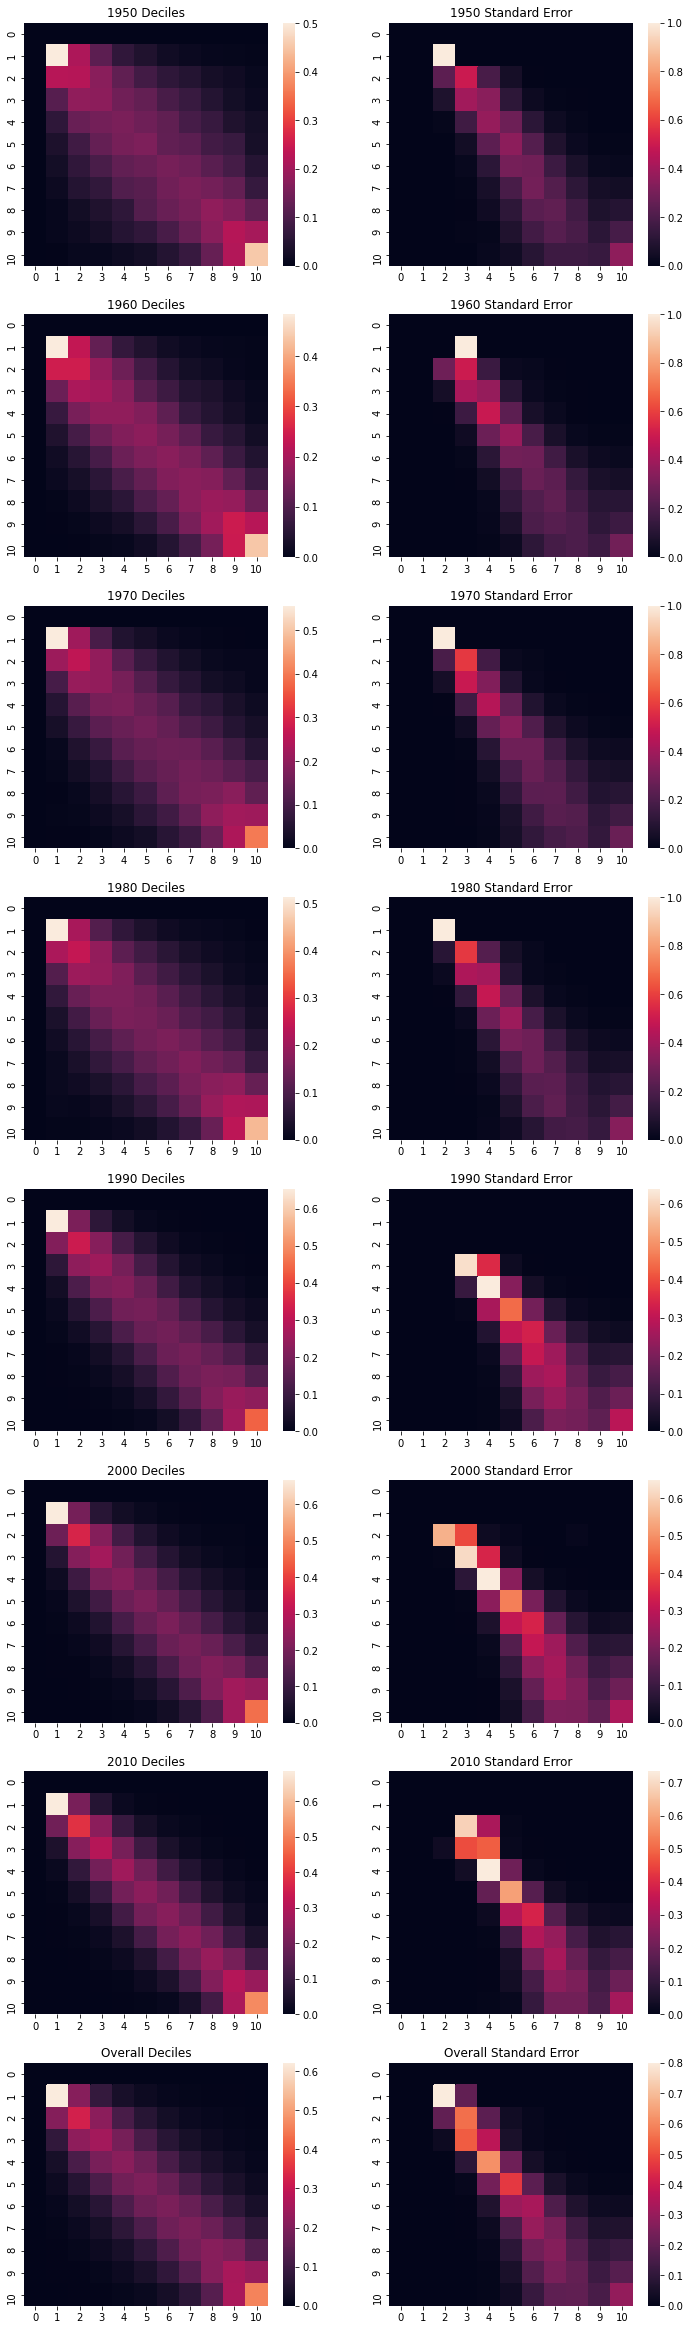

In [41]:
n_decades = 7
fig, axes = plt.subplots(nrows=n_decades + 1, ncols=2, figsize=(12, 42))
for i in range(n_decades):
    mat = np.load(f'wrds_results/ch1/transition_mat_deciles_{str(1950 + i * 10)}.npy')
    sns.heatmap(mat, ax=axes[i][0])
    mat = np.load(f'wrds_results/ch1/transition_mat_stderr_{str(1950 + i * 10)}.npy')
    sns.heatmap(mat, ax=axes[i][1])
    
    axes[i][0].set_title(f'{str(1950 + i * 10)} Deciles')
    axes[i][1].set_title(f'{str(1950 + i * 10)} Standard Error')
    
mat = np.load(f'wrds_results/ch1/transition_mat_deciles_overall.npy')
sns.heatmap(mat, ax=axes[n_decades][0])
mat = np.load(f'wrds_results/ch1/transition_mat_stderr_overall.npy')
sns.heatmap(mat, ax=axes[n_decades][1])

axes[n_decades][0].set_title(f'Overall Deciles')
axes[n_decades][1].set_title(f'Overall Standard Error')
plt.show()

Next we show heatmaps of the average values for previous periods

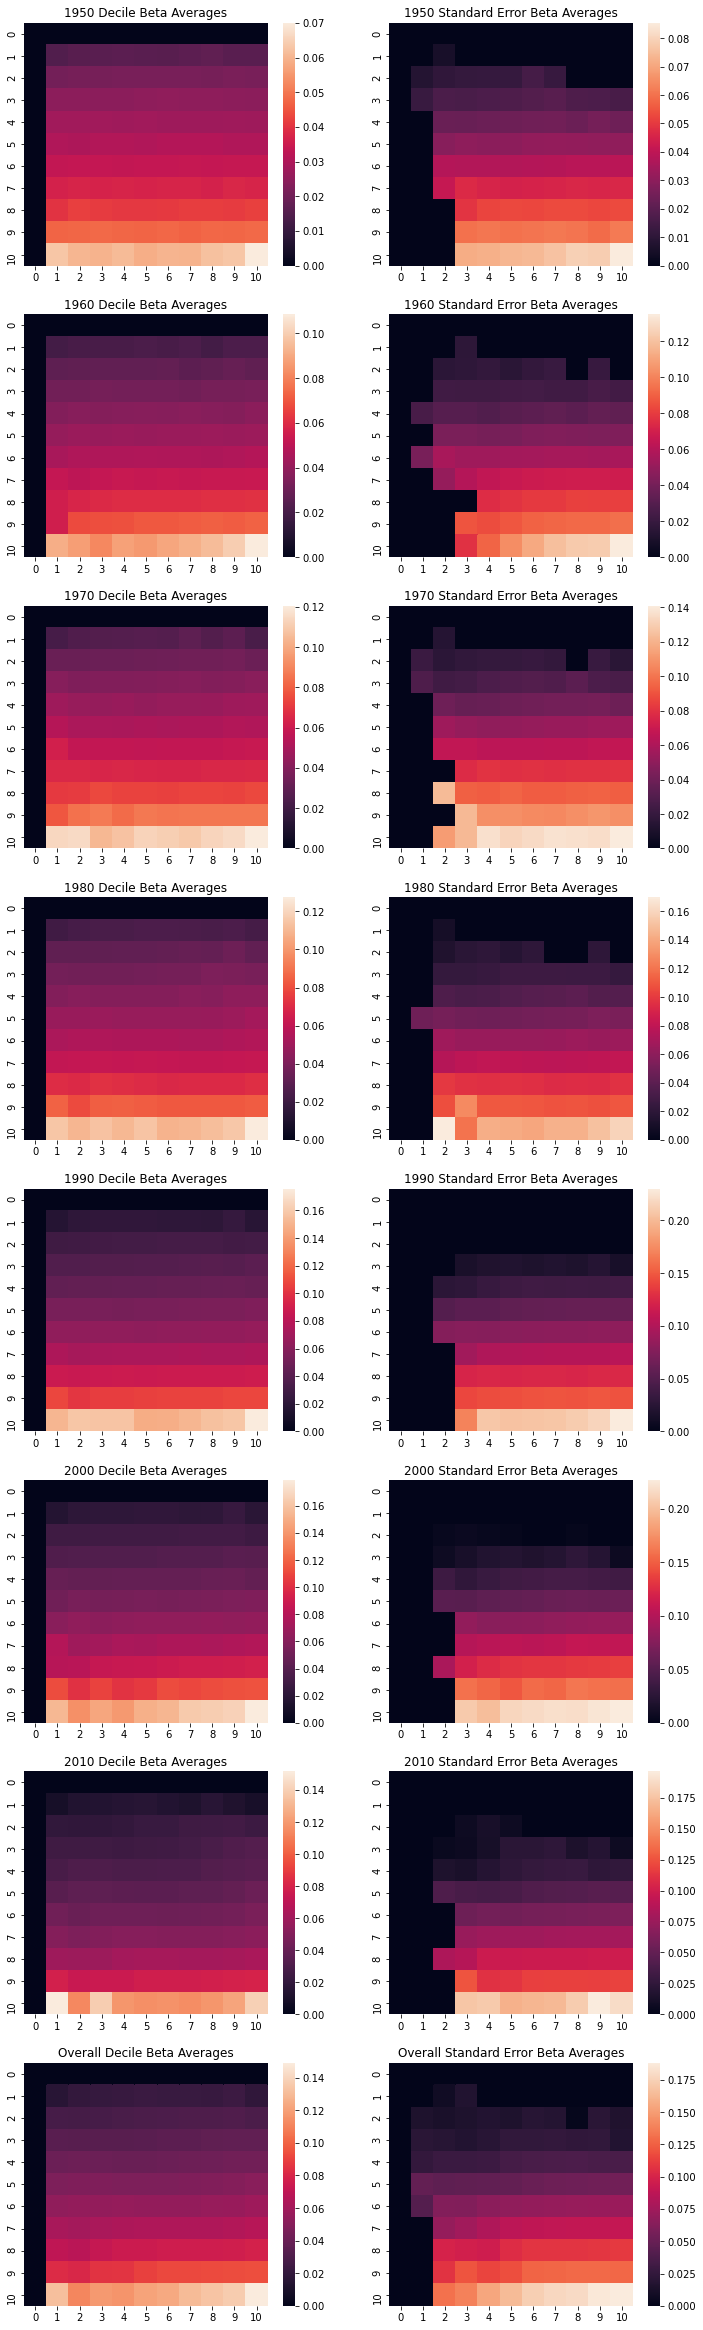

In [40]:
n_decades = 7
fig, axes = plt.subplots(nrows=n_decades + 1, ncols=2, figsize=(12, 42))
for i in range(n_decades):
    mat = np.load(f'wrds_results/ch1/prev_average_mat_deciles_{str(1950 + i * 10)}.npy')
    sns.heatmap(mat, ax=axes[i][0])
    mat = np.load(f'wrds_results/ch1/prev_average_mat_stderr_{str(1950 + i * 10)}.npy')
    sns.heatmap(mat, ax=axes[i][1])
    
    axes[i][0].set_title(f'{str(1950 + i * 10)} Decile Beta Averages')
    axes[i][1].set_title(f'{str(1950 + i * 10)} Standard Error Beta Averages')
    
mat = np.load(f'wrds_results/ch1/prev_average_mat_deciles_overall.npy')
sns.heatmap(mat, ax=axes[n_decades][0])
mat = np.load(f'wrds_results/ch1/prev_average_mat_stderr_overall.npy')
sns.heatmap(mat, ax=axes[n_decades][1])

axes[n_decades][0].set_title(f'Overall Decile Beta Averages')
axes[n_decades][1].set_title(f'Overall Standard Error Beta Averages')
plt.show()

Finally, we show the current average volatility values.

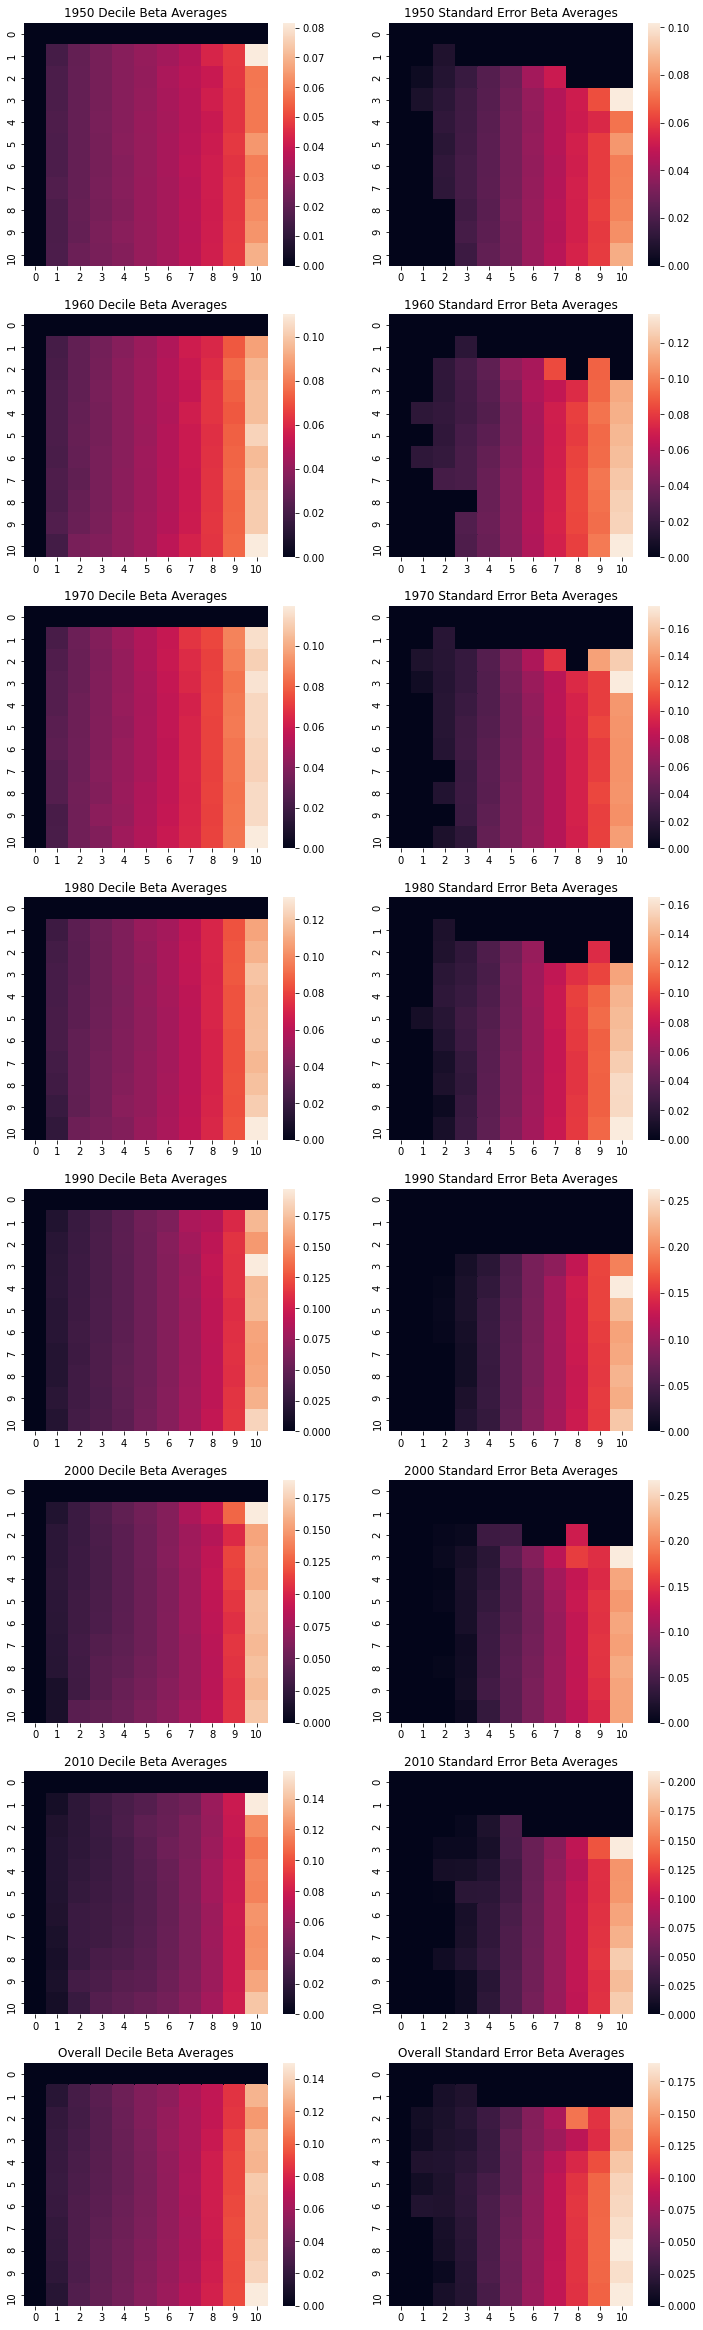

In [63]:
n_decades = 7
fig, axes = plt.subplots(nrows=n_decades + 1, ncols=2, figsize=(12, 42))
for i in range(n_decades):
    mat = np.load(f'wrds_results/ch1/post_average_mat_deciles_{str(1950 + i * 10)}.npy')
    sns.heatmap(mat, ax=axes[i][0])
    mat = np.load(f'wrds_results/ch1/post_average_mat_stderr_{str(1950 + i * 10)}.npy')
    sns.heatmap(mat, ax=axes[i][1])
    
    axes[i][0].set_title(f'{str(1950 + i * 10)} Decile Beta Averages')
    axes[i][1].set_title(f'{str(1950 + i * 10)} Standard Error Beta Averages')
    
mat = np.load(f'wrds_results/ch1/post_average_mat_deciles_overall.npy')
sns.heatmap(mat, ax=axes[n_decades][0])
mat = np.load(f'wrds_results/ch1/post_average_mat_stderr_overall.npy')
sns.heatmap(mat, ax=axes[n_decades][1])

axes[n_decades][0].set_title(f'Overall Decile Beta Averages')
axes[n_decades][1].set_title(f'Overall Standard Error Beta Averages')
plt.show()

## Convert to Excel Format
Finally, we'll go ahead and save these transition matrices in .xlsx format, cause it's nice to have.

In [57]:
n_decades = 7
for i in range(n_decades):
    mat = np.load(f'wrds_results/ch1/transition_mat_deciles_{str(1950 + i * 10)}.npy')
    df = pd.DataFrame(mat).iloc[1:].drop(columns=0)
    df.to_excel(f'wrds_results/ch1/Excel/transition_mat_deciles_{str(1950 + i * 10)}.xlsx')
    
    mat = np.load(f'wrds_results/ch1/transition_mat_stderr_{str(1950 + i * 10)}.npy')
    df = pd.DataFrame(mat).iloc[1:].drop(columns=0)
    df.to_excel(f'wrds_results/ch1/Excel/transition_mat_stderr_{str(1950 + i * 10)}.xlsx')

mat = np.load(f'wrds_results/ch1/transition_mat_deciles_overall.npy')
df = pd.DataFrame(mat).iloc[1:].drop(columns=0)
df.to_excel(f'wrds_results/ch1/Excel/transition_mat_deciles_overall.xlsx')

mat = np.load(f'wrds_results/ch1/transition_mat_stderr_overall.npy')
df = pd.DataFrame(mat).iloc[1:].drop(columns=0)
df.to_excel(f'wrds_results/ch1/Excel/transition_mat_stderr_overall.xlsx')

In [62]:
# Excel
n_decades = 7
for i in range(n_decades):
    mat = np.load(f'wrds_results/ch1/transition_mat_deciles_{str(1950 + i * 10)}.npy')
    pd.DataFrame(mat).iloc[1:].drop(columns=0).to_excel(f'wrds_results/ch1/Excel/transition_mat_deciles_{str(1950 + i * 10)}.xlsx')
    mat = np.load(f'wrds_results/ch1/transition_mat_stderr_{str(1950 + i * 10)}.npy')
    pd.DataFrame(mat).iloc[1:].drop(columns=0).to_excel(f'wrds_results/ch1/Excel/transition_mat_stderr_{str(1950 + i * 10)}.xlsx')
    mat = np.load(f'wrds_results/ch1/post_average_mat_deciles_{str(1950 + i * 10)}.npy')
    pd.DataFrame(mat).iloc[1:].drop(columns=0).to_excel(f'wrds_results/ch1/Excel/post_avg_deciles_{str(1950 + i * 10)}.xlsx')
    mat = np.load(f'wrds_results/ch1/post_average_mat_stderr_{str(1950 + i * 10)}.npy')
    pd.DataFrame(mat).iloc[1:].drop(columns=0).to_excel(f'wrds_results/ch1/Excel/post_avg_stderr_{str(1950 + i * 10)}.xlsx')
    mat = np.load(f'wrds_results/ch1/prev_average_mat_deciles_{str(1950 + i * 10)}.npy')
    pd.DataFrame(mat).iloc[1:].drop(columns=0).to_excel(f'wrds_results/ch1/Excel/prev_avg_deciles_{str(1950 + i * 10)}.xlsx')
    mat = np.load(f'wrds_results/ch1/prev_average_mat_stderr_{str(1950 + i * 10)}.npy')
    pd.DataFrame(mat).iloc[1:].drop(columns=0).to_excel(f'wrds_results/ch1/Excel/prev_avg_stderr_{str(1950 + i * 10)}.xlsx')
    
mat = np.load(f'wrds_results/ch1/prev_average_mat_deciles_overall.npy')
pd.DataFrame(mat).iloc[1:].drop(columns=0).to_excel(f'wrds_results/ch1/Excel/prev_avg_deciles_overall.xlsx')
mat = np.load(f'wrds_results/ch1/prev_average_mat_stderr_overall.npy')
pd.DataFrame(mat).iloc[1:].drop(columns=0).to_excel(f'wrds_results/ch1/Excel/prev_avg_stderr_overall.xlsx')    

mat = np.load(f'wrds_results/ch1/post_average_mat_deciles_overall.npy')
pd.DataFrame(mat).iloc[1:].drop(columns=0).to_excel(f'wrds_results/ch1/Excel/post_avg_deciles_overall.xlsx')
mat = np.load(f'wrds_results/ch1/post_average_mat_stderr_overall.npy')
pd.DataFrame(mat).iloc[1:].drop(columns=0).to_excel(f'wrds_results/ch1/Excel/post_avg_stderr_overall.xlsx')

## Notes

The average values for chapter 1 have a lot more holes on the stderr side of things. This seems to be genuinely because volatility has a much higher minimum average standard error (higher than 1), so these holes just appear since often there aren't values below the 2nd bin.